<div  >
<img src="https://raw.githubusercontent.com/threeML/astromodels/master/docs/media/transp_logo.png" alt="drawing" width="300" align="right"/>
 


<div  >
<img src="https://raw.githubusercontent.com/threeML/threeML/master/logo/logo_sq.png" alt="drawing" width="300" align="right"/>



# X-ray Analysis with 3ML
    
While 3ML can handle a lot of different data/likelihood types a lot of attention was spent on making sure that users familiar with past community standards are able to easily adapt to the 3ML workflow. There are some guides for these users in the [documentation](https://threeml.readthedocs.io/en/stable/xspec_users.html).
    
X-ray analysis in 3ML is centered around the `OGIPLike` plugin which reads OGIP style PHAI/II, RMF, and ARF files. the OGIPLike plugin is a specialized version of the `DispersionSpectrumLike` plugin which deals with count data that are produced by convolving the model spectrum with the resonse of an instrument that suffers from energy dispersion. Thus, if you have an instrument you are designing and you don't like fits files... inherit from DispersionSpectrumLike and create your own unique plugin for ROOT, HDF5, txt, etc. files. The cool thing is that you can still fit your data along with normal OGIP type data... or any of the other plugins in the 3ML family. 3ML is a toolbox to bring instruments (and people) together. 
    
    
Let's explore the OGIPLike plugin

 


## The OGIPLike plugin

The OGIP plugin reads in standard OGIP files. **It will complain a lot if files are in the correct format!**. For PHAII files with multiple spectra, you can use the familiar `<filename>{<spectrum_number>}` format to specify file names or you can pass a spectrum number as an argument. 

<img src="https://cdn.pixabay.com/photo/2012/11/28/11/16/star-67705_960_720.jpg" alt="drawing" width="400" align="center"/>


In the tutorial, there are some simulated Chandra data. Let's say that these data come from the observation of a a white drawf atmosphere. Let's see what we can do with these data.


In [2]:
from threeML import *
# get xspec models
from astromodels.xspec import *

# this is the basic interface to 
# logging. see the documentation for more
update_logging_level("INFO")
silence_warnings()

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

%matplotlib notebook
from jupyterthemes import jtplot
jtplot.style(context='notebook', fscale=1, ticks=True, grid=False)


In [7]:
chandra = OGIPLike(name="chandra", 
                   observation="c_data/obs.pha", 
                   background="c_data/obs_bak.pha",
                   response="c_data/acis.rmf",
                   arf_file="c_data/acis.arf",
                   spectrum_number=1 )

[INFO    ] Auto-probed noise models:
[INFO    ] - observation: poisson
[INFO    ] - background: poisson


Note that 3ML probed the type of data that were read in. As long as the data files have been appropriately labelled, the plugin will **choose the correct likelihood for you**. While freedom is a great thing, math is not a democracy and thus we follow the rules so that your fits are of the highest scientific rigour. 

In this case, the total observation and the background observation are Poisson distributed. Thus, the proper likelihood is a Poisson for the total observation conditional ont he Poisson likelihood of the background. For now, we will not model the background. Therefore a profile likelihood will be choosen.

Let's examine the properties of the plugin.


In [3]:
chandra.significance

81.60661293154533

In [4]:
chandra.significance_per_channel

array([ 0.67686759, -0.        ,  1.18439965, ..., -0.        ,
       -0.        , -0.        ])

<IPython.core.display.Javascript object>


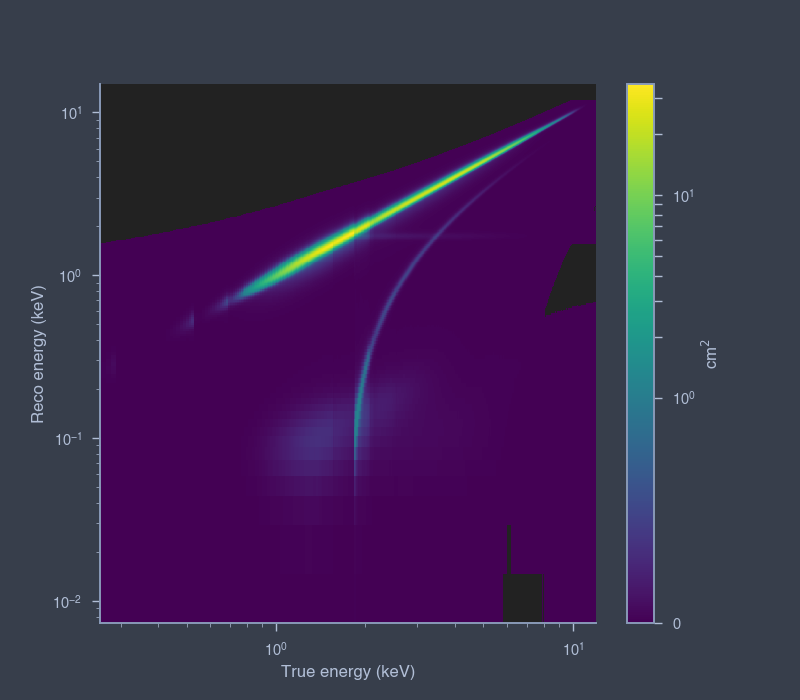


WARNING MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()



In [5]:
chandra.display_rsp()

In [6]:
chandra.exposure

1.0

<IPython.core.display.Javascript object>


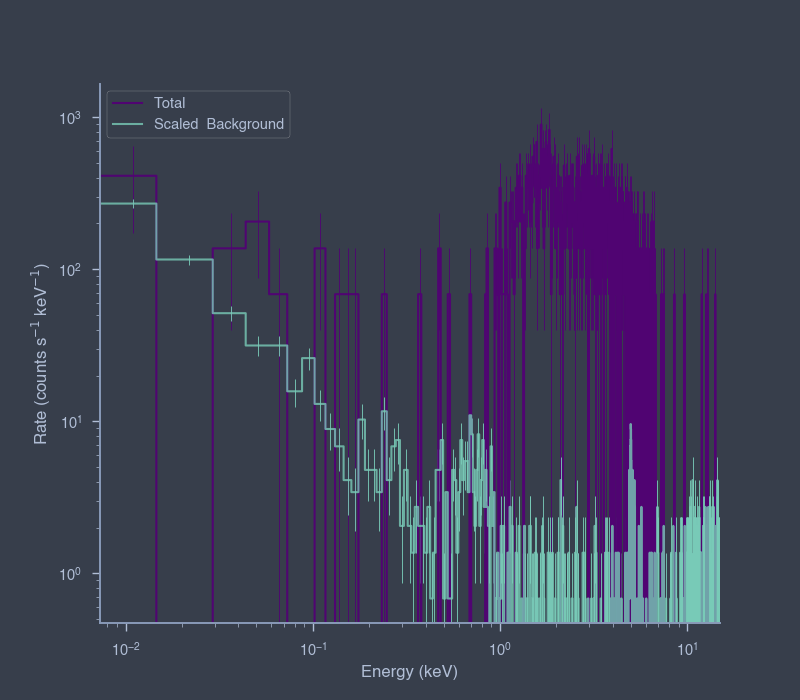

In [7]:
chandra.view_count_spectrum(scale_background=True);

Now, not all channels are great to use in an analysis. Thus, we can set our selections.

In [8]:
chandra.set_active_measurements?

In [9]:
chandra.set_active_measurements('0.2-10')

[INFO    ] Range 0.2-10 translates to channels 13-684


<IPython.core.display.Javascript object>


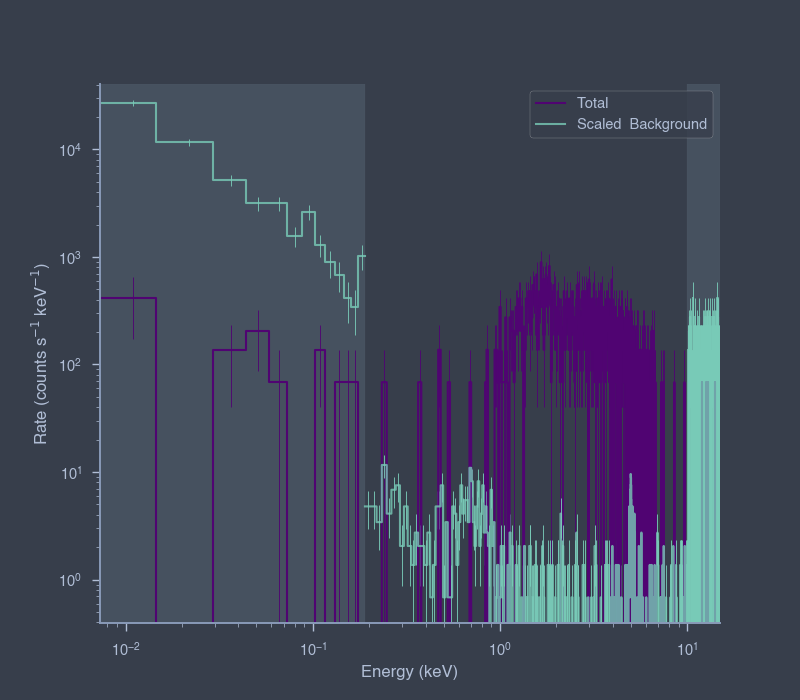


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [10]:
chandra.view_count_spectrum();

For profile likelihoods to valid, there must be at least 1 [background count per channel](https://giacomov.github.io/Bias-in-profile-poisson-likelihood/). Let's do that here:

In [8]:
chandra.rebin_on_background(1)
#chandra.remove_rebinning()

[INFO    ] Now using 434 bins


<IPython.core.display.Javascript object>


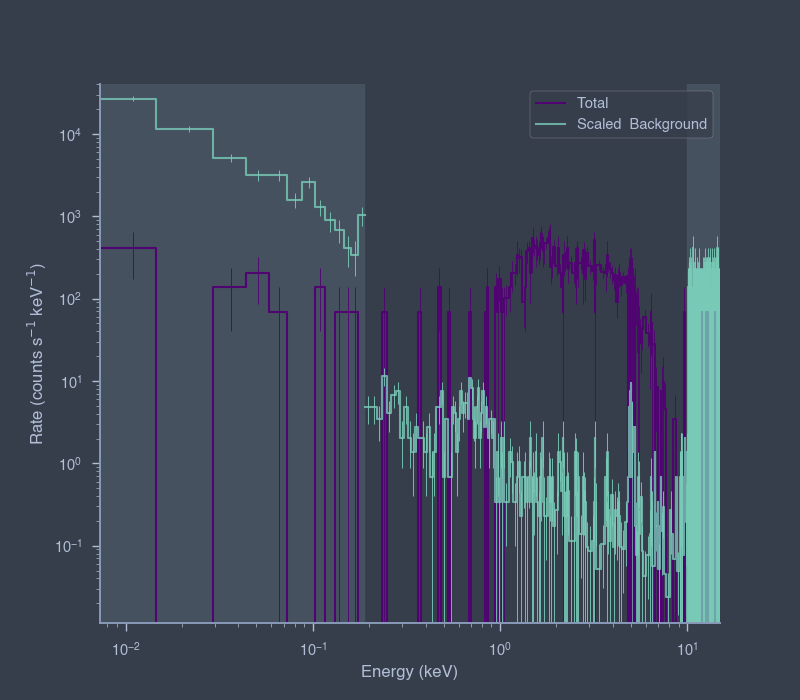


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [12]:
chandra.view_count_spectrum();

## Fitting 

Ok, we are basically ready to do a fit. But we need a model. Let's make two models, one of a black body and the other a power law. We are going to be Bayesians for now, but remember, there is little difference between the interface for the two approaches.

### blackbody model


In [5]:
bb = Blackbody()


#priors
bb.K.prior = Log_uniform_prior(lower_bound = 1e-2, upper_bound = 20)
bb.kT.prior = Truncated_gaussian(mu= 1, sigma=2, lower_bound=0, upper_bound=10)


# you can also try with the XSPEC blackbody!

# bb = XS_bbody()
# #priors
# bb.norm.prior = Log_uniform_prior(lower_bound = 1e-2, upper_bound = 20)
# bb.kt.prior = Truncated_gaussian(mu= 1, sigma=2, lower_bound=0, upper_bound=10)

# source
ps_bb = PointSource("white_drawf_bb", 0, 0, spectral_shape=bb)

# model
model_bb = Model(ps_bb)

In [9]:
bayes_bb = BayesianAnalysis(model_bb, DataList(chandra))

# let's use ultranest this time
bayes_bb.set_sampler("ultranest")

bayes_bb.sampler.setup(min_num_live_points=400)

_ = bayes_bb.sample()

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-9e+02  .60 [-872.6143..-872.6143]*| it/evals=5240/7319 eff=75.7190% N=399  9  
[ultranest] Likelihood function evaluations: 7361
[ultranest]   logZ = -881.2 +- 0.1099
[ultranest] Effective samples strategy satisfied (ESS = 1617.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.21, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
white_drawf_bb.spectrum.main.XS_bbody.kt,(9.63 -0.25 +0.24) x 10^-1,keV
white_drawf_bb.spectrum.main.XS_bbody.norm,(2.42 +/- 0.08) x 10^-1,keV / (cm2 s)



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-872.52755
total,-872.52755



Values of statistical measures:



,statistical measures
AIC,1749.066852
BIC,1758.918043
DIC,1749.165747
PDIC,2.050184
log(Z),-382.707797



WARNING MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()



<IPython.core.display.Javascript object>


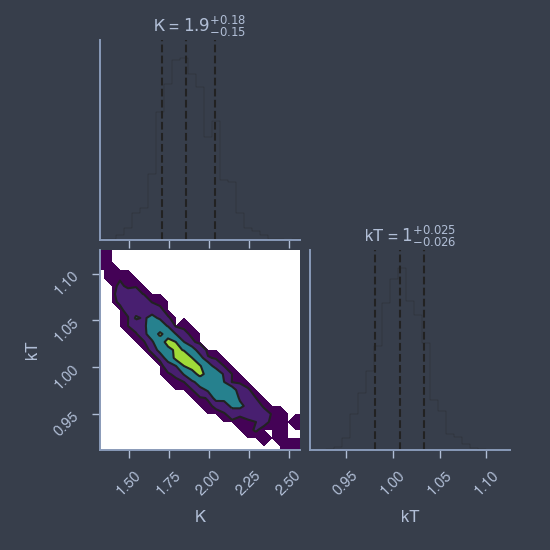

In [15]:
bayes_bb.results.corner_plot();

<IPython.core.display.Javascript object>


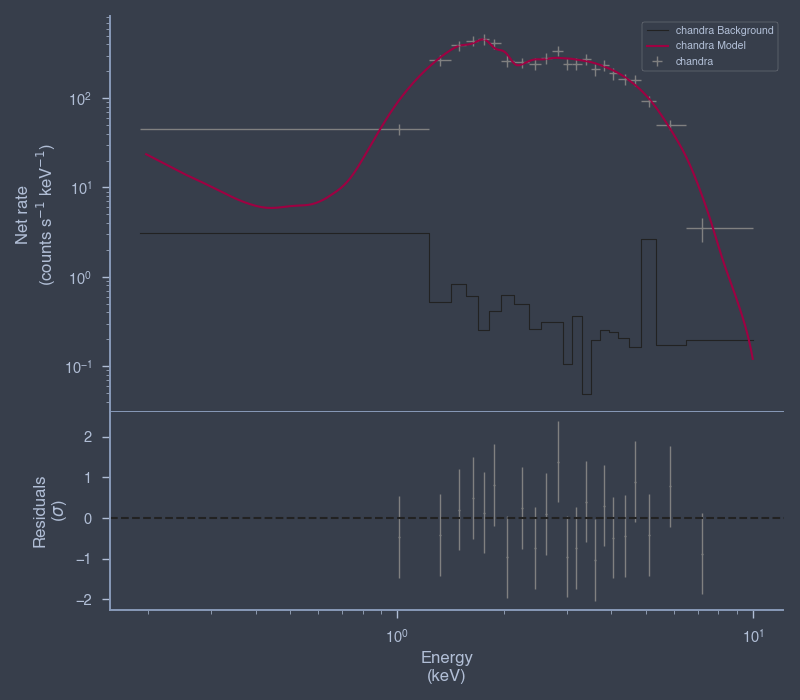


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [16]:
display_spectrum_model_counts(bayes_bb,
                              min_rate=50,
                              show_background=True);



In [17]:
show_configuration('plugins')

plugins
 ╠═ ogip
 ║  ╠═ fit_plot
 ║  ║  ╠═ data_cmap
 ║  ║  ║  ╚═ MPLCmap.Set1
 ║  ║  ╠═ model_cmap
 ║  ║  ║  ╚═ MPLCmap.Spectral
 ║  ║  ╠═ background_cmap
 ║  ║  ║  ╚═ MPLCmap.Set1
 ║  ║  ╠═ n_colors
 ║  ║  ║  ╚═ 5
 ║  ║  ╠═ step
 ║  ║  ║  ╚═ False
 ║  ║  ╠═ show_legend
 ║  ║  ║  ╚═ True
 ║  ║  ╠═ show_residuals
 ║  ║  ║  ╚═ True
 ║  ║  ╠═ data_color
 ║  ║  ║  ╚═ grey
 ║  ║  ╠═ model_color
 ║  ║  ║  ╚═ None
 ║  ║  ╠═ background_color
 ║  ║  ║  ╚═ k
 ║  ║  ╠═ show_background
 ║  ║  ║  ╚═ False
 ║  ║  ╠═ data_mpl_kwargs
 ║  ║  ║  ╚═ None
 ║  ║  ╠═ model_mpl_kwargs
 ║  ║  ║  ╚═ None
 ║  ║  ╚═ background_mpl_kwargs
 ║  ║     ╠═ lw
 ║  ║     ║  ╚═ 0.8
 ║  ║     ╚═ ls
 ║  ║        ╚═ -
 ║  ╠═ data_plot
 ║  ║  ╠═ counts_color
 ║  ║  ║  ╚═ #500472
 ║  ║  ╠═ background_color
 ║  ║  ║  ╚═ #79cbb8
 ║  ║  ╠═ warn_channels_color
 ║  ║  ║  ╚═ #C79BFE
 ║  ║  ╠═ bad_channels_color
 ║  ║  ║  ╚═ #FE3131
 ║  ║  ╚═ masked_channels_color
 ║  ║     ╚═ #566573
 ║  ╠═ response_cmap
 ║  ║  ╚═ MPLCmap.viridis


In [18]:
threeML_config.plugins.ogip.fit_plot.data_color = 'limegreen'
threeML_config.plugins.ogip.fit_plot.model_color = '#FF5AFD'

<IPython.core.display.Javascript object>


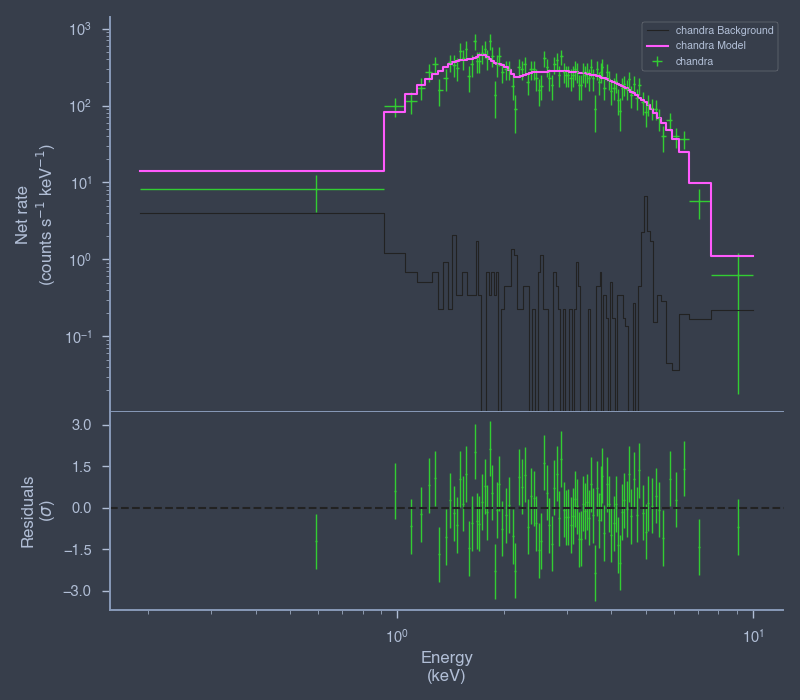


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [19]:
display_spectrum_model_counts(bayes_bb,
                              min_rate=10,
                              step=True,
                              show_background=True);




### power law model

In [20]:
plaw = Powerlaw()

plaw.K.prior = Log_uniform_prior(lower_bound = 1e-2, upper_bound = 10) 

plaw.index.prior = Gaussian(mu=-1, sigma=2)
plaw.index.bounds = (None, None)


# source
ps_pl = PointSource("white_drawf_pl", 0, 0, spectral_shape=plaw)

# model
model_pl = Model(ps_pl)

In [21]:
bayes_pl = BayesianAnalysis(model_pl, DataList(chandra))

# let's use ultranest this time
bayes_pl.set_sampler("ultranest")

bayes_pl.sampler.setup(min_num_live_points=400)

_ = bayes_pl.sample()

[INFO    ] sampler set to ultranest
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+02  .30 [-652.3109..-652.3109]*| it/evals=5000/6914 eff=76.7578% N=400 400  
[ultranest] Likelihood function evaluations: 6949
[ultranest]   logZ = -660.3 +- 0.08229
[ultranest] Effective samples strategy satisfied (ESS = 1541.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.18, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
white_drawf_pl.spectrum.main.Powerlaw.K,2.23 -0.14 +0.13,1 / (cm2 keV s)
white_drawf_pl.spectrum.main.Powerlaw.index,-1.12 -0.05 +0.06,



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-653.350058
total,-653.350058



Values of statistical measures:



,statistical measures
AIC,1310.718053
BIC,1319.720633
DIC,1310.444290
PDIC,1.871351
log(Z),-286.748954


<IPython.core.display.Javascript object>


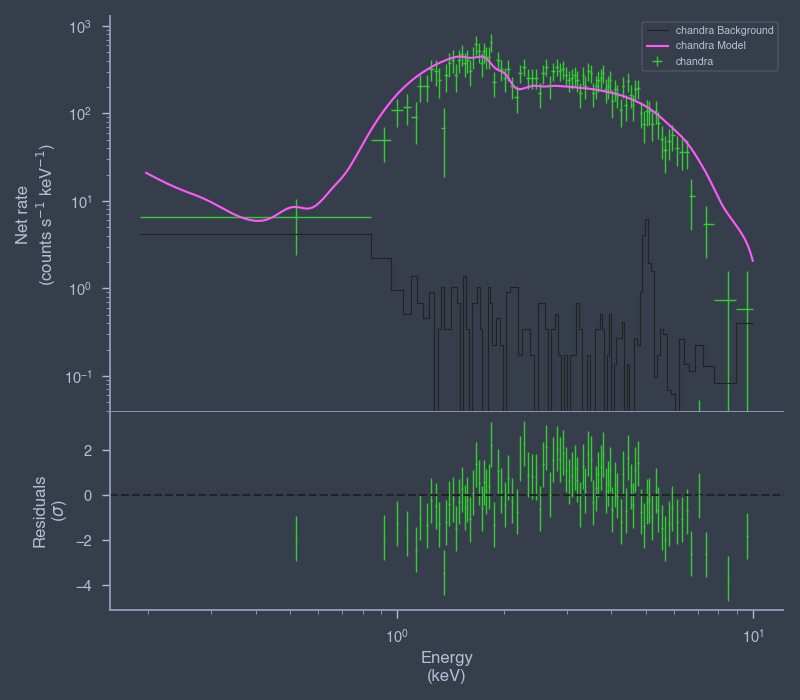


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [22]:
display_spectrum_model_counts(bayes_pl,
                              min_rate=10,
                              show_background=True);

processing Bayesian analyses:   0%|          | 0/2 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

Propagating errors:   0%|          | 0/100 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


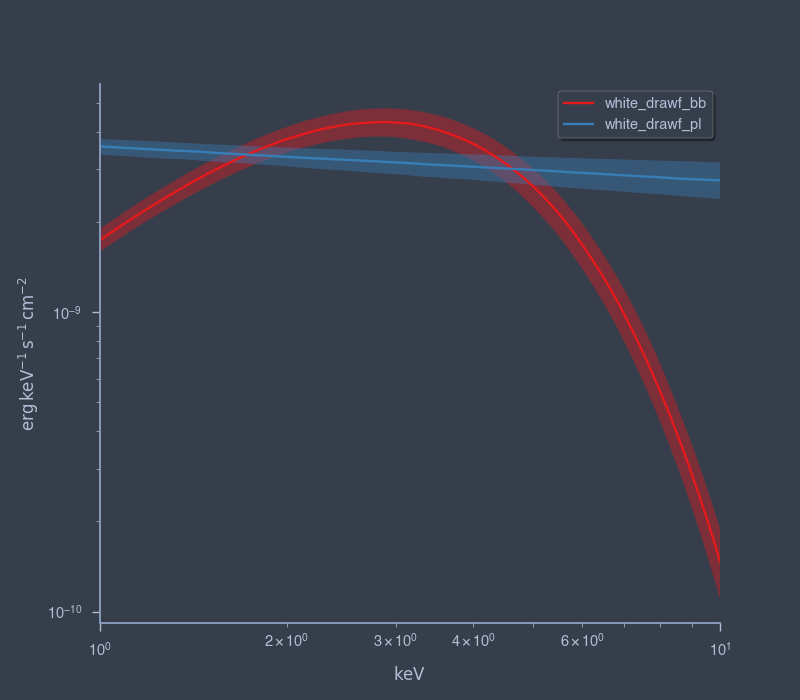

In [23]:
plot_spectra(bayes_bb.results, bayes_pl.results,
             flux_unit="erg/(cm2 s keV)",
             ene_min=1*u.keV, ene_max=10*u.keV);

## posterior predictive checks (PPC)

Let's use an external package to 3ML (but built with its tools box!) to compute posterior predictive checks. PPCs are model checking tool that integrate over the posterior and likelihood to compute the probability of new data from the observed data. We can compute this via simulating new data from the likelihood for sampled points from our posterior. A more detailed explanation for this can be found [here](https://academic.oup.com/mnras/article/490/1/927/5570608).

In [24]:
from twopc import compute_ppc

In [25]:
ppc_bb = compute_ppc(bayes_bb,
                  bayes_bb.results,
                  n_sims=500,
                  file_name="ppc_bb.h5",
                  return_ppc=True, overwrite=True)

sampling posterior:   0%|          | 0/500 [00:00<?, ?it/s]

In [26]:
xx = ppc_bb.chandra.ppc_counts[0] - ppc_bb.chandra.scale_factor* ppc_bb.chandra.ppc_background[0]

<IPython.core.display.Javascript object>


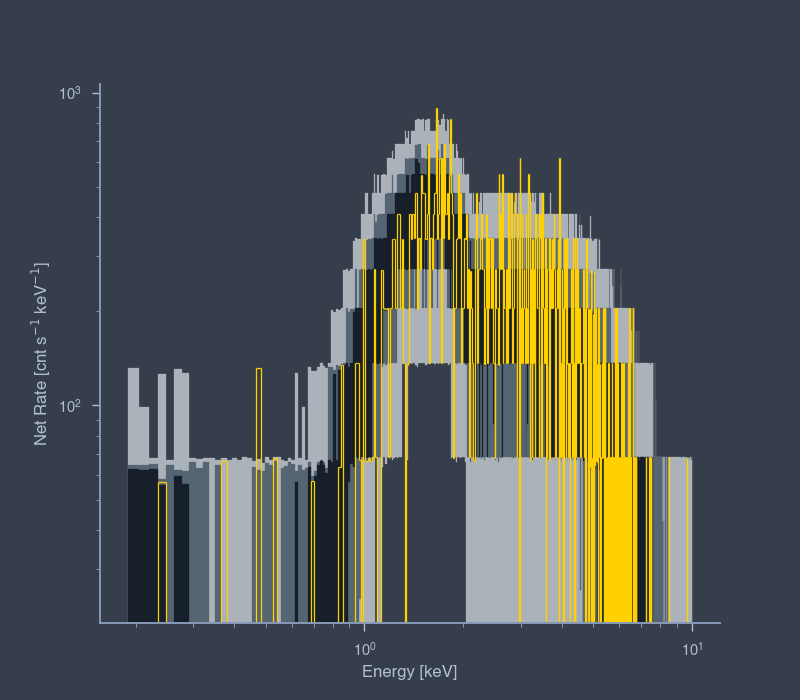

In [27]:
ppc_bb.chandra.plot(bkg_subtract=True);

<IPython.core.display.Javascript object>


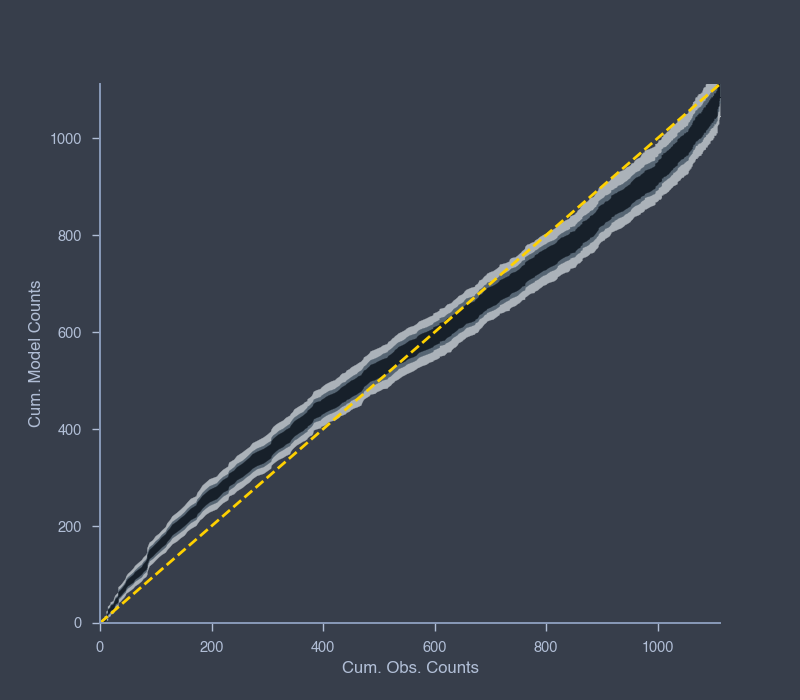

In [28]:
ppc_bb.chandra.plot_qq(channel_energies=None);

In [29]:
ppc_pl = compute_ppc(bayes_pl,
                  bayes_pl.results,
                  n_sims=500,
                  file_name="ppc_pl.h5",
                  return_ppc=True, overwrite=True)

sampling posterior:   0%|          | 0/500 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


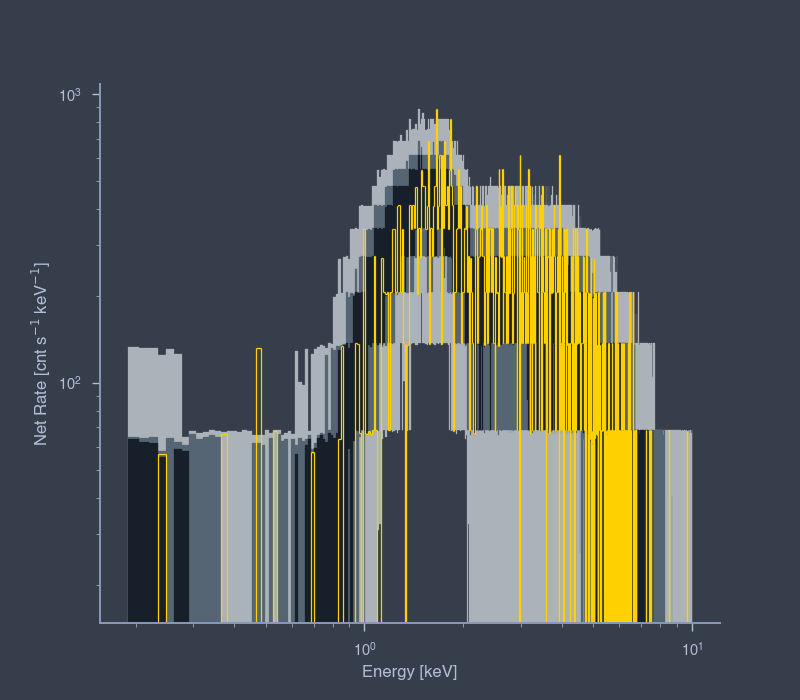

In [30]:
ppc_pl.chandra.plot(bkg_subtract=True);

<IPython.core.display.Javascript object>


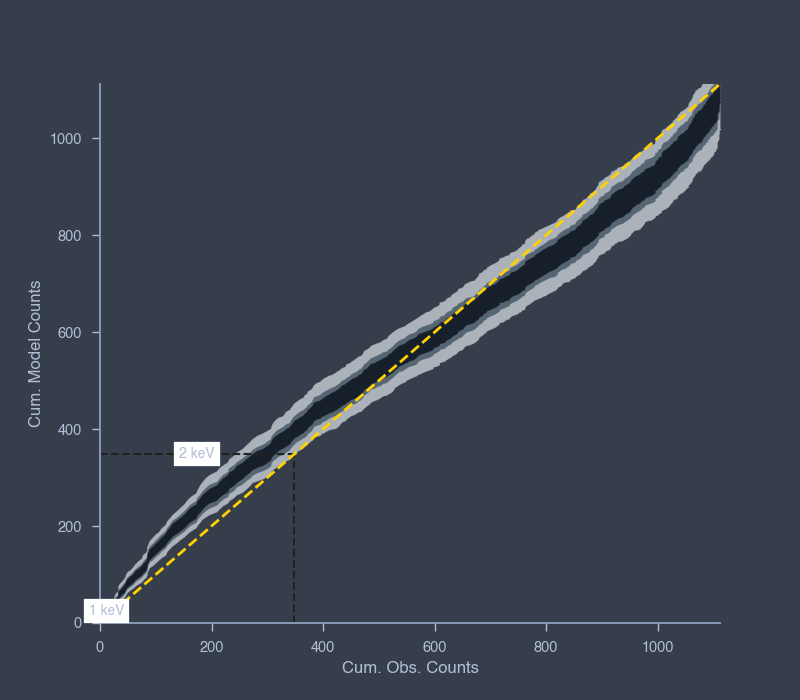

In [31]:
ppc_pl.chandra.plot_qq(channel_energies=[1,2]);

## Background modeling

While profile likelihoods are a great tool when we have no good model for the background, if we can model the background, we should. It is possible to introduce models for the background in 3ML by extracting a plugin with the background spectrum only from a normal OGIPLike plugin. 


<img src="https://upload.wikimedia.org/wikipedia/commons/f/f1/Artist_impression_of_a_supermassive_black_hole_at_the_centre_of_a_galaxy.jpg" alt="drawing" width="400" align="center"/>

This time we look at some simulated data where we are trying to find a spectral line on top of a continuum. The source is a blackhole accreation disk. First, let's load the data and have a look




[WARNING ] Maximum MC energy (12.0) is smaller than maximum EBOUNDS energy (14.950400352478027)
[WARNING ] Minimum MC energy (0.2549999952316284) is larger than minimum EBOUNDS energy (0.007300000172108412)


<IPython.core.display.Javascript object>


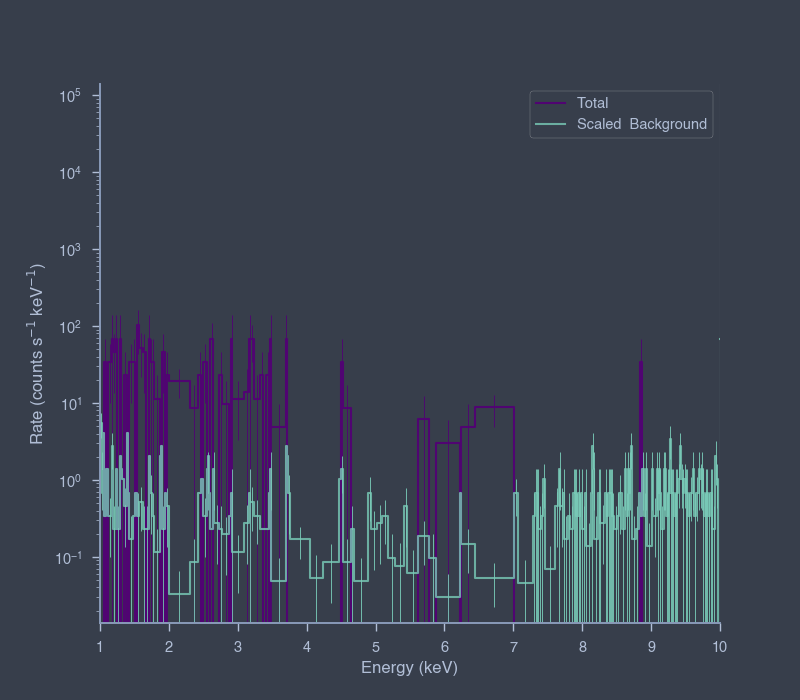


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [32]:
chandra = OGIPLike(name="chandra", 
                   observation="c_data/obs_bkg_demo.pha", 
                   background="c_data/obs_bkg_demo_bak.pha",
                   response="c_data/acis.rmf",
                   arf_file="c_data/acis.arf",
                   spectrum_number=1 )


chandra.set_active_measurements("1-10")

chandra.rebin_on_background(1)

fig = chandra.view_count_spectrum(scale_background=True);

ax =fig.get_axes()[0]

ax.set_xlim(1,10)
ax.set_xscale('linear')





Now let's build our model and fit.

In [33]:
cpl = Powerlaw(piv=5) + Gaussian()

#priors
cpl.K_1.prior = Log_uniform_prior(lower_bound = 1e-4, upper_bound = 1)
#cpl.xc_1.prior = Truncated_gaussian(mu= 5, sigma=3, lower_bound=1, upper_bound=12)
cpl.index_1.prior = Truncated_gaussian(mu= -2, sigma=1, lower_bound=-np.inf, upper_bound=0)

cpl.F_2.prior = Log_uniform_prior(lower_bound = 1e-3, upper_bound = 1)
cpl.mu_2.prior = Truncated_gaussian(mu= 6.4, sigma=2, lower_bound=1, upper_bound=10)
cpl.sigma_2.prior = Log_uniform_prior(lower_bound = 1e-3, upper_bound = 1)
# source
ps_blackhole = PointSource("blackhole", 0, 0, spectral_shape=cpl)

# model
model_blackhole = Model(ps_blackhole)





In [34]:
bayes = BayesianAnalysis(model_blackhole, DataList(chandra))

# let's use ultranest this time
bayes.set_sampler("multinest")

bayes.sampler.setup(n_live_points=500,verbose=True                       )

In [35]:
_ = bayes.sample()

  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
blackhole.spectrum.main.composite.K_1,(1.23 +/- 0.30) x 10^-2,1 / (cm2 keV s)
blackhole.spectrum.main.composite.index_1,-1.90 -0.26 +0.25,
blackhole.spectrum.main.composite.F_2,(2.9 -1.6 +1.5) x 10^-2,1 / (cm2 s)
blackhole.spectrum.main.composite.mu_2,6.63 -0.15 +0.17,keV
blackhole.spectrum.main.composite.sigma_2,(8 -8 +7) x 10^-2,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-315.552061
total,-315.552061



Values of statistical measures:



,statistical measures
AIC,641.202323
BIC,663.228468
DIC,640.617750
PDIC,2.905590
log(Z),-142.923823


<IPython.core.display.Javascript object>


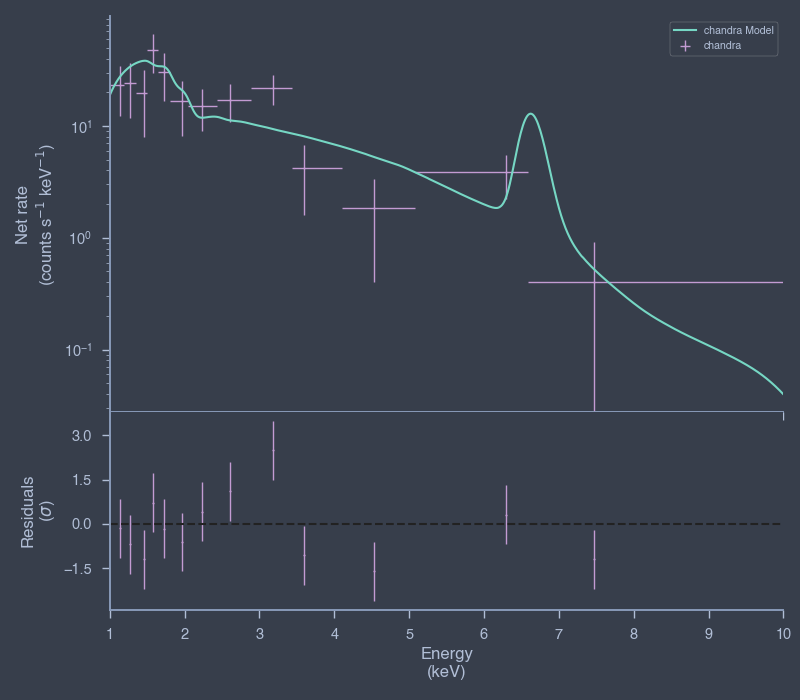


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [36]:
fig = chandra.display_model(step=False, min_rate=5,
                               data_color="#C39BD3", model_color="#76D7C4",
                               
                               )

ax = fig.get_axes()[0]

ax.set_xlim(1,10)

ax.set_xscale('linear')



<IPython.core.display.Javascript object>


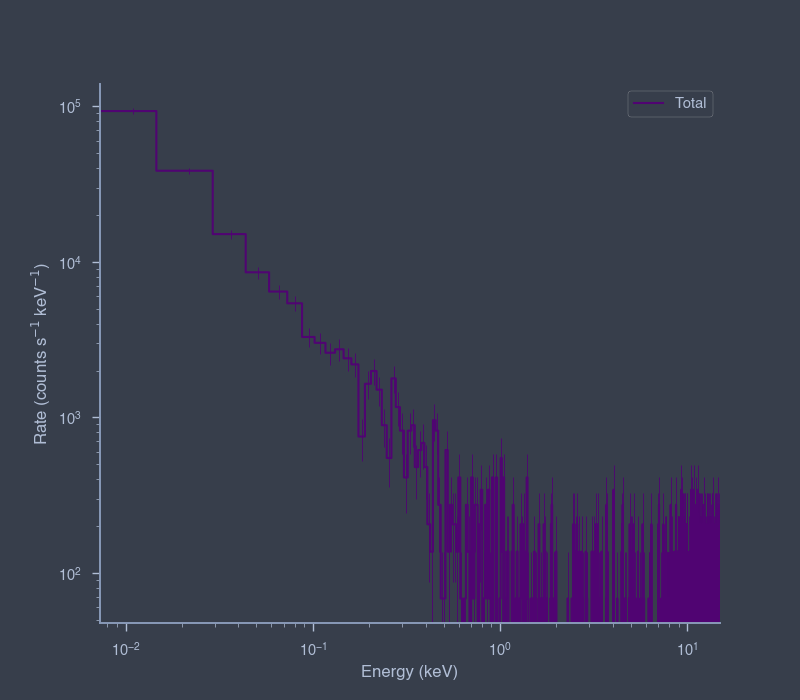

In [37]:
chandra.remove_rebinning()

bkg_plugin = SpectrumLike.from_background("bkg", chandra)

bkg_plugin.view_count_spectrum();


In [38]:
bkg_spectrum = Powerlaw(K=1.e0,index=-1.2, piv=5) + Gaussian(F=1e0, mu=1, sigma=.2) 

bkg_spectrum.K_1.prior = Log_uniform_prior(lower_bound=1e-2, upper_bound=1e2)
bkg_spectrum.index_1.prior = Truncated_gaussian(mu = -1.2, sigma=0.5, lower_bound=-np.inf, upper_bound=0)

bkg_spectrum.F_2.prior = Log_uniform_prior(lower_bound=1e-2, upper_bound=1e2)
bkg_spectrum.mu_2.prior = Truncated_gaussian(mu = 3, sigma=1, lower_bound=0, upper_bound=10)
bkg_spectrum.sigma_2.fix = True


bkg_src = PointSource("bkg", 0,0, spectral_shape=bkg_spectrum)

bkg_model = Model(bkg_src)


bkg_plugin.set_model(bkg_model)



In [39]:
chandra_bkg = OGIPLike("chandra",
                       observation = "c_data/obs_bkg_demo.pha",
                       response = "c_data/acis.rmf", 
                       arf_file = "c_data/acis.arf" ,
                       background = bkg_plugin,
                       spectrum_number=1
                        
                      
                      )


chandra_bkg.set_active_measurements("1-10")



[WARNING ] Maximum MC energy (12.0) is smaller than maximum EBOUNDS energy (14.950400352478027)
[WARNING ] Minimum MC energy (0.2549999952316284) is larger than minimum EBOUNDS energy (0.007300000172108412)


<IPython.core.display.Javascript object>


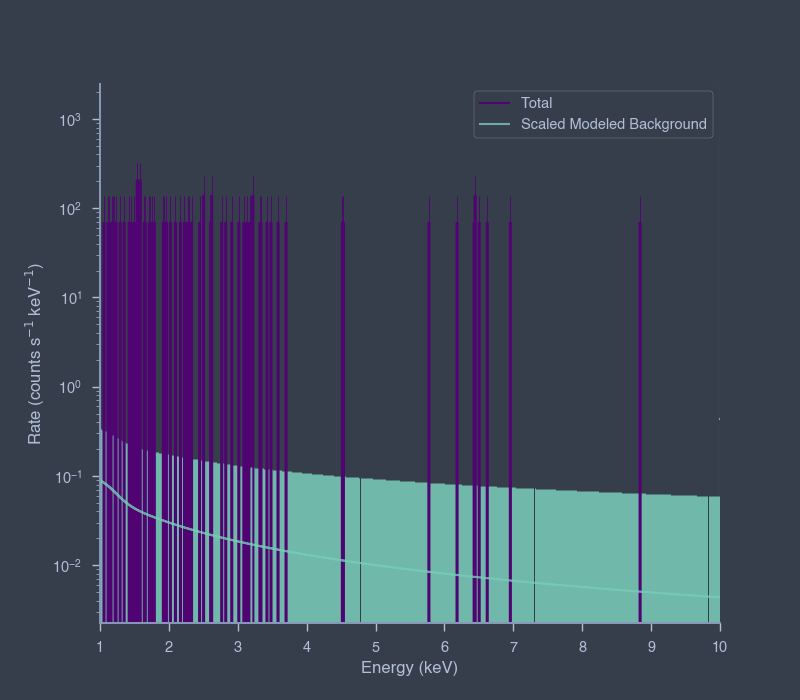


WARNING UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.



In [40]:
fig = chandra_bkg.view_count_spectrum();

ax =fig.get_axes()[0]

ax.set_xlim(1,10)
ax.set_xscale('linear')

In [41]:
chandra_bkg.nuisance_parameters

OrderedDict([('cons_chandra',
              Parameter cons_chandra = 1.0 []
              (min_value = 0.8, max_value = 1.2, delta = 0.05, free = False)),
             ('bkg_bkg_position_ra_chandra',
              Parameter ra = 0.0 [deg]
              (min_value = 0.0, max_value = 360.0, delta = 0.1, free = False)),
             ('bkg_bkg_position_dec_chandra',
              Parameter dec = 0.0 [deg]
              (min_value = -90.0, max_value = 90.0, delta = 0.1, free = False)),
             ('bkg_bkg_spectrum_main_composite_K_1_chandra',
              Parameter K_1 = 1.0 [1 / (cm2 keV s)]
              (min_value = 1e-30, max_value = 1000.0, delta = 0.1, free = True) [prior: Log_uniform_prior]),
             ('bkg_bkg_spectrum_main_composite_piv_1_chandra',
              Parameter piv_1 = 5.0 [keV]
              (min_value = None, max_value = None, delta = 0.1, free = False)),
             ('bkg_bkg_spectrum_main_composite_index_1_chandra',
              Parameter index_1 = -1.2 []


In [42]:


new_model = clone_model(model_blackhole)


bayes_bkg = BayesianAnalysis(new_model, DataList(chandra_bkg))


bayes_bkg.set_sampler("multinest")

bayes_bkg.sampler.setup(n_live_points=500,verbose=True )

[WARNING ] External parameter cons_chandra already exist in the model. Overwriting it...


In [43]:
_ = bayes_bkg.sample()

  analysing data from chains/fit-.txt
Maximum a posteriori probability (MAP) point:



,result,unit
parameter,,
blackhole.spectrum.main.composite.K_1,(1.19 -0.31 +0.32) x 10^-2,1 / (cm2 keV s)
blackhole.spectrum.main.composite.index_1,-1.89 +/- 0.27,
blackhole.spectrum.main.composite.F_2,(2.6 +/- 1.5) x 10^-2,1 / (cm2 s)
blackhole.spectrum.main.composite.mu_2,6.48 -0.10 +0.07,keV
blackhole.spectrum.main.composite.sigma_2,(7 -7 +6) x 10^-2,keV
K_1,(4.11 +/- 0.14) x 10,1 / (cm2 keV s)
index_1,-1.207 -0.008 +0.009,
F_2,(3.3 -3.1 +2.7) x 10^-1,1 / (cm2 s)
mu_2,3.0 +/- 0.9,keV



Values of -log(posterior) at the minimum:



,-log(posterior)
chandra,-2048.410729
total,-2048.410729



Values of statistical measures:



,statistical measures
AIC,4115.117999
BIC,4154.645280
DIC,4111.174573
PDIC,4.656467
log(Z),-899.252358


In [44]:
threeML_config.bayesian.corner_style.cmap = "magma"
threeML_config.bayesian.corner_style.extremes="none"


WARNING MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("magma").copy()



<IPython.core.display.Javascript object>


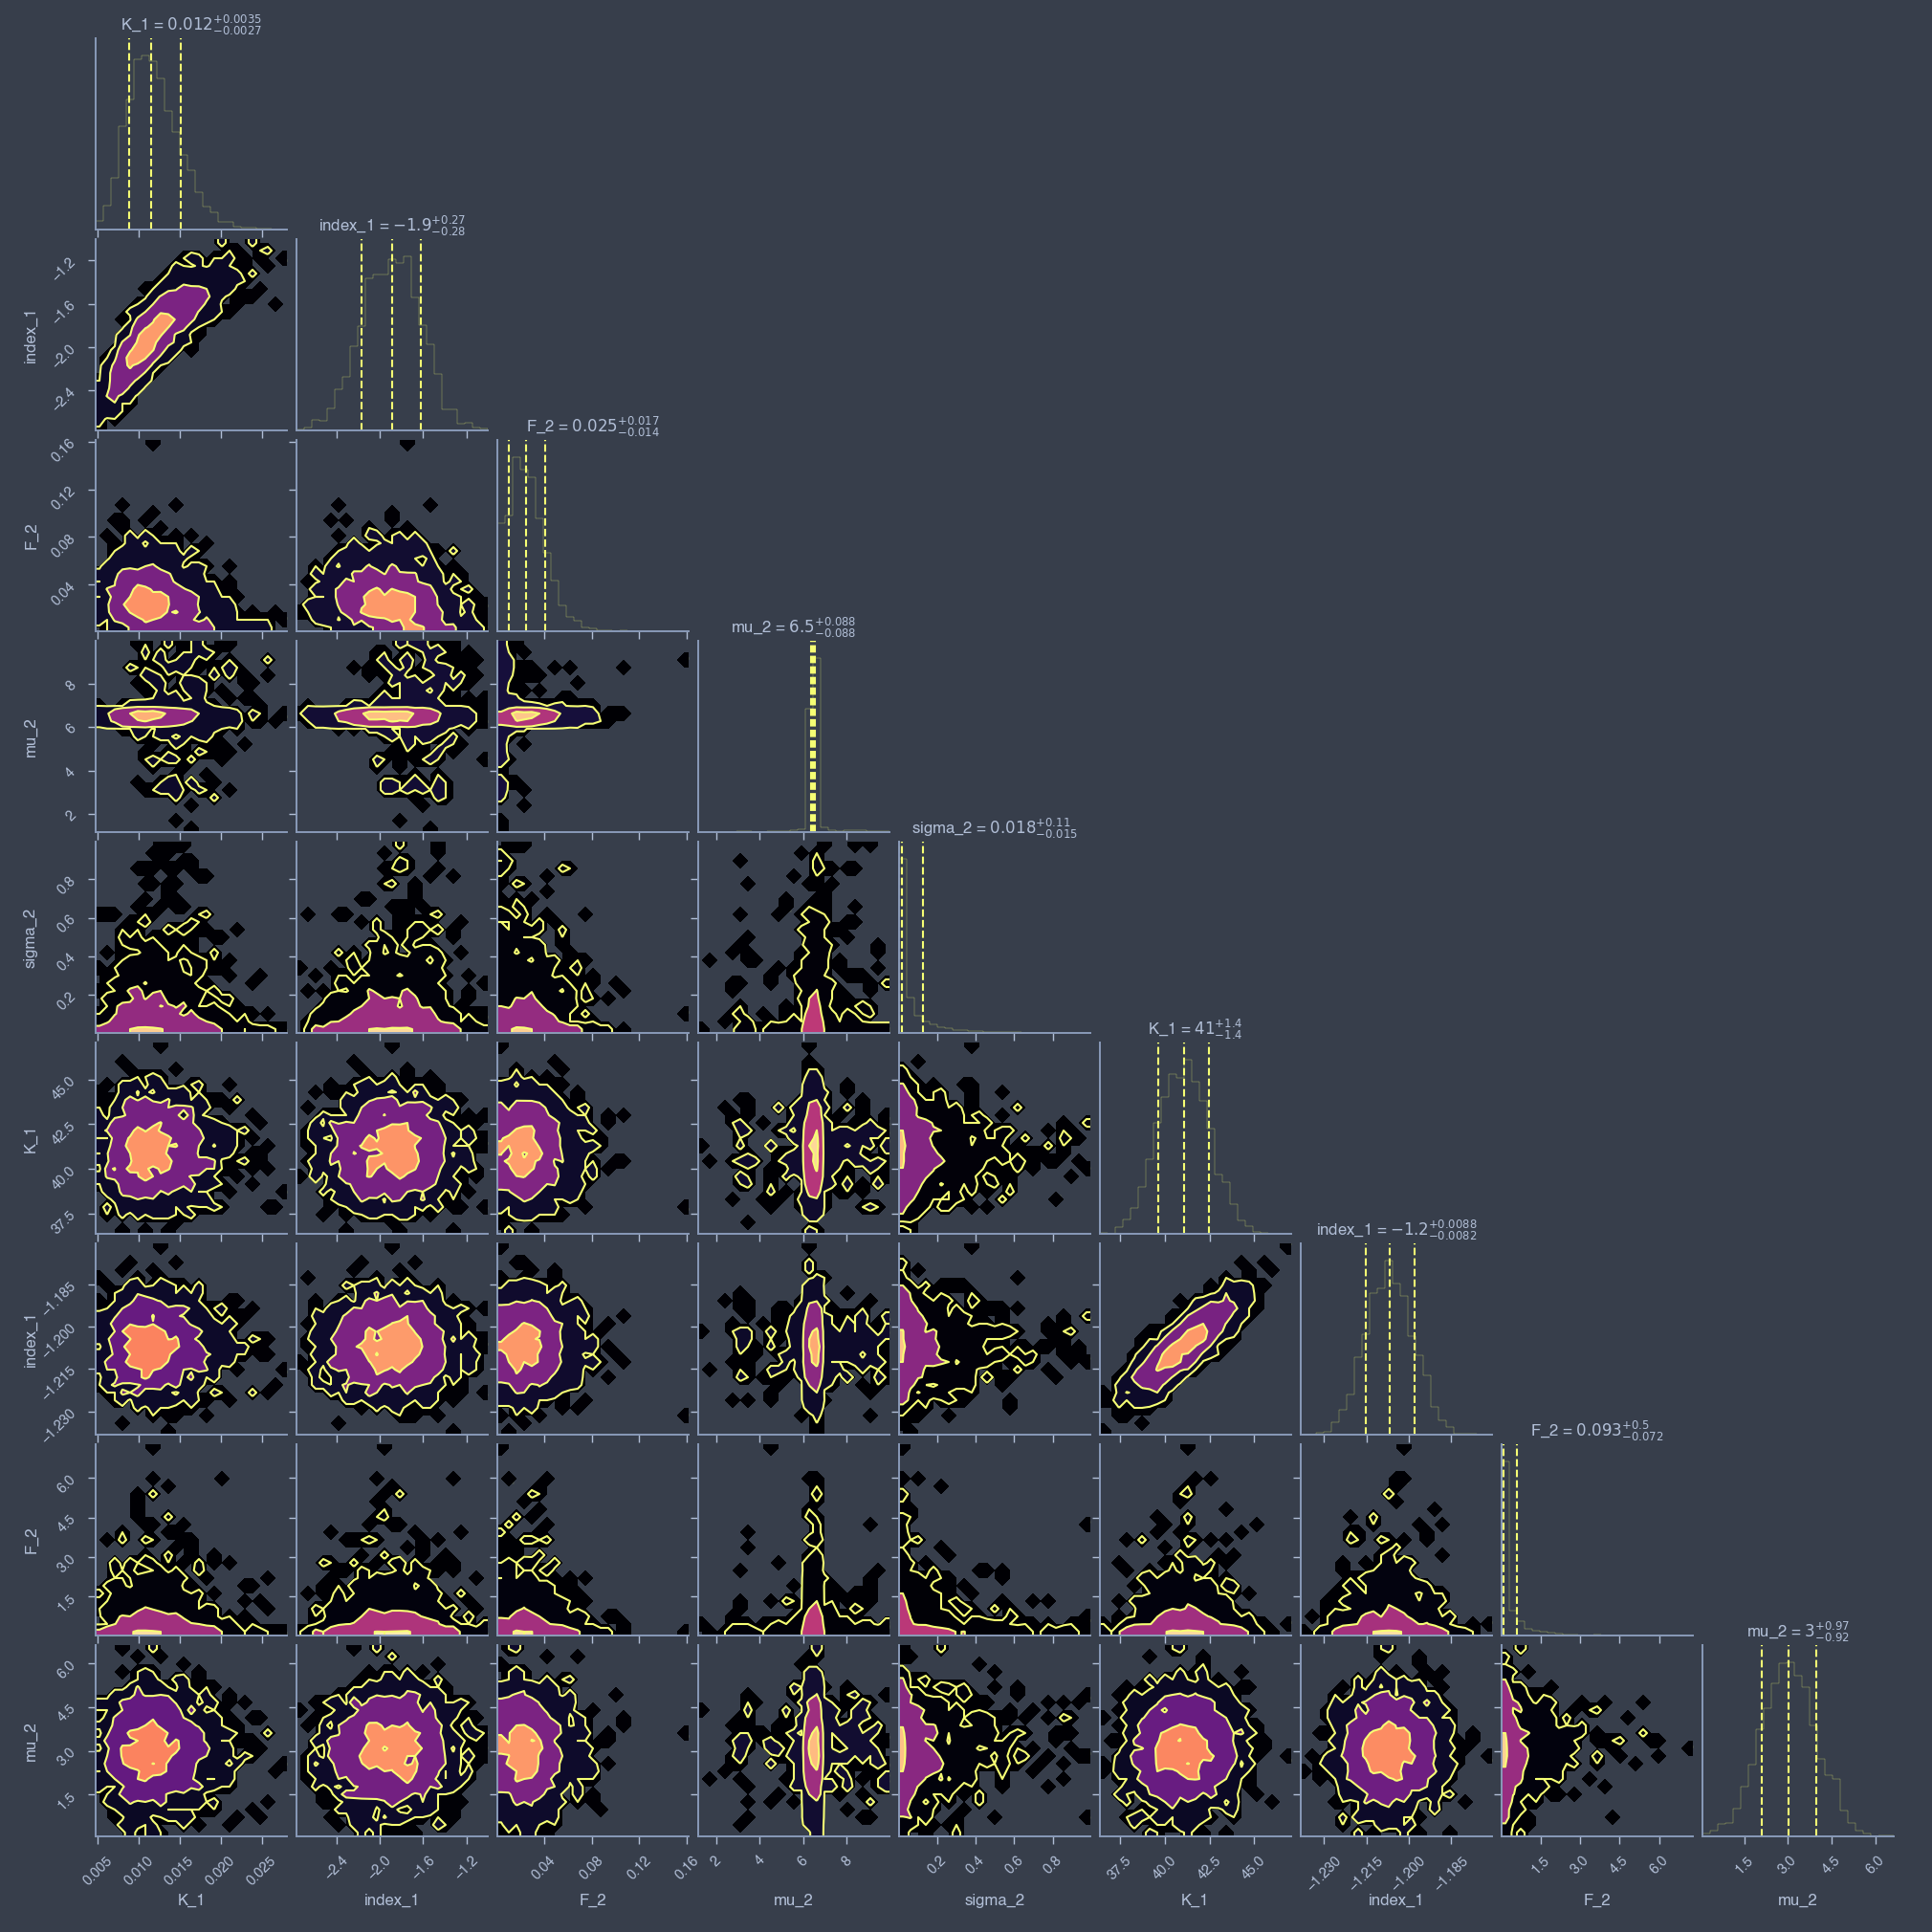

In [45]:
bayes_bkg.results.corner_plot(color="#F6FF74");

<IPython.core.display.Javascript object>


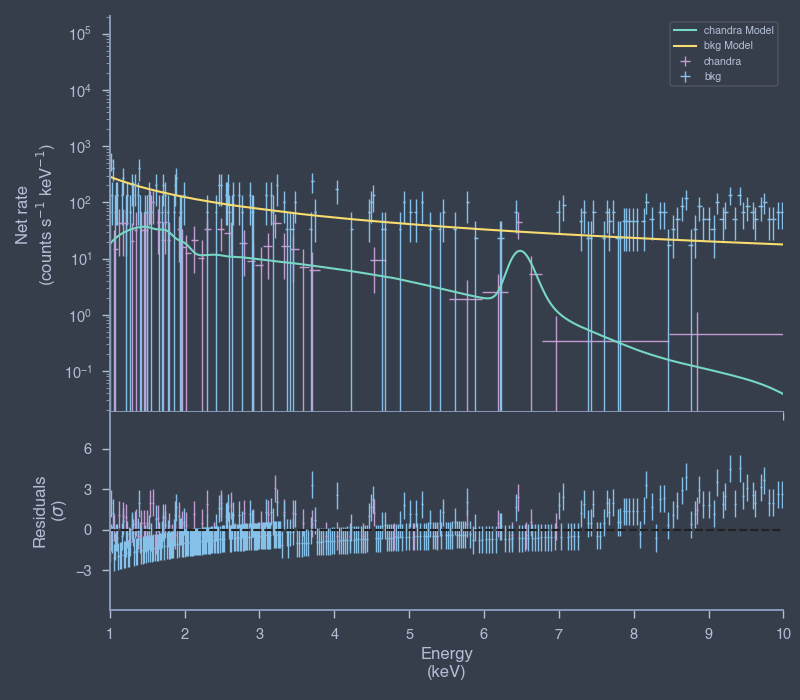


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.


WARNING MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.



In [46]:
# over plot the joint background and source fits
fig = chandra_bkg.display_model(step=False, min_rate=1,
                               data_color="#C39BD3", model_color="#76D7C4",
                               
                               )

_ = bkg_plugin.display_model(
    data_color="#85C1E9", model_color="#F7DC6F",
    model_subplot=fig.axes,
    step=False,
    min_rate=1
)

ax = fig.get_axes()[0]

ax.set_xlim(1,10)

ax.set_xscale('linear')



The OGIP plugin (or any plugin) is not just for fitting, it can be used as a generic interface between models and isntruments for building pipelines. 
* Plugins and models are serializable meaning they can be farmed out to multi-processing
* Most plugins can simulate data from their likelihoods (complex instruments still need some work here)

Let's try this out: